# Using the Detailed DHC-A Dataset

The [Detailed Demographic and Housing Characteristic File A (Detailed DHC-A)](https://www.census.gov/programs-surveys/decennial-census/decade/2020/planning-management/release/about-2020-data-products.html#d-dhcfilea)
was released on September 21, 2023. The next day, I put this notebook together to demonstrate how easy it is to load new
datasets with `censusdis`. It is not necessary to fork, modify, or update `censusdis` in any way to handle new data sets. 
Indeed, one of the key [design goals of censusdis](https://github.com/vengroff/censusdis/blob/main/design-goals.md) was
that it should handle new data sets and changes of variables from year to year without requiring code changes.

The DHC-A data set contains, "population counts and sex by age statistics for approximately 1,500 detailed racial and ethnic groups,
such as German, Lebanese, Jamaican, Chinese, Native Hawaiian, and Mexican, as well as American Indian
and Alaska Native (AIAN) tribes and villages like the Navajo Nation."

This notebook demonstrates how to access and analyze this data set with the `censusdis` package. It does the following:

1. Load metadata on DHC-A.
2. Load data on total population of various ractial groups
   for every county in the 50 states and DC.
3. For every county with more than 1,000 Asian residents, compute
   the fraction of Asian residents belonging to each of several
   subgroups, e.g. Korean, Vietnamese, ...
4. Plot the results on maps.

## Basic imports

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC

import divintseg as dis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Setup

For more details on what we are setting up here, see the comments 
in this [introductory notebook](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb).


In [4]:
CENSUS_API_KEY = None

In [5]:
YEAR = 2020
DATASET = "dec/ddhca"

What groups are in the dataset?

In [6]:
groups = ced.variables.all_groups(DATASET, YEAR)

groups

,DATASET,YEAR,GROUP,DESCRIPTION
0,dec/ddhca,2020,T01001,TOTAL POPULATION
1,dec/ddhca,2020,T02001,SEX BY AGE (4 AGE CATEGORIES)
2,dec/ddhca,2020,T02002,SEX BY AGE (9 AGE CATEGORIES)
3,dec/ddhca,2020,T02003,SEX BY AGE (23 AGE CATEGORIES)


We will choose the group containing total population, since we are not interested in age at this time.

In [7]:
GROUP = "T01001"

We want data for all states.

In [8]:
states = ALL_STATES_AND_DC

## Fetch metadata

We will fetch the metadata on what variables are available. Total
population is what we are looking for.

In [9]:
df_all_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)

df_all_variables

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,dec/ddhca,T01001,T01001_001N,!!Total,NaN,None


## Fetch County Data

We add `POPGROUP` so we know what population group each row corresponds to. This is the key field that this data set contains that is new and different compared to how the U.S. Census tracked race and ethnicity in the past. `POPGROUP_LABEL` is a human-readible form of this.

In [10]:
df_counties = ced.download(
    DATASET,
    YEAR,
    ["NAME", "POPGROUP", "POPGROUP_LABEL", "T01001_001N"],
    state=states,
    county="*",
    api_key=CENSUS_API_KEY,
)

In [11]:
df_counties.head()

,STATE,COUNTY,NAME,POPGROUP,POPGROUP_LABEL,T01001_001N
0,01,001,"Autauga County, Alabama",1002,European alone,20657.0
1,01,001,"Autauga County, Alabama",1011,Belgian alone,23.0
2,01,001,"Autauga County, Alabama",1013,British alone,24.0
3,01,001,"Autauga County, Alabama",1021,Czech alone,24.0
4,01,001,"Autauga County, Alabama",1023,Dutch alone,86.0


## Fetch the total Asian Population

Following guidance found in the [2020 Census Detailed Demographic
and Housing Characteristics File A
(Detailed DHC-A) Technical
Documentation](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/detailed-demographic-and-housing-characteristics-file-a/2020census-detailed-dhc-a-techdoc.pdf),
we are going to compute the fraction of the Asian population that is from each group by using the total population of each county from the [2020 Census
Redistricting Data
(P.L. 94-171)](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html).

In [12]:
DEC_PL_DATASET = "dec/pl"

Find the variable that counts all of the population that reported being of one race, Asian alone.

In [13]:
df_pl_variables = ced.variables.all_variables(DEC_PL_DATASET, YEAR, "P1")

In [14]:
df_pl_variables[df_pl_variables["LABEL"].str.contains("Asian alone")]

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
5,2020,dec/pl,P1,P1_006N,!!Total:!!Population of one race:!!Asian alone,NaN,None


Load this variable for all counties.

In [15]:
df_pl_all_counties = ced.download(
    DEC_PL_DATASET,
    YEAR,
    ["P1_006N"],
    state=states,
    county="*",
    api_key=CENSUS_API_KEY,
)

Just to check our work, we'll add up the total Asian population and make sure it matches the number given in the [2020 Census Detailed Demographic
and Housing Characteristics File A
(Detailed DHC-A) Technical
Documentation](https://www2.census.gov/programs-surveys/decennial/2020/technical-documentation/complete-tech-docs/detailed-demographic-and-housing-characteristics-file-a/2020census-detailed-dhc-a-techdoc.pdf)

In [16]:
df_pl_all_counties.sum(numeric_only=True)

P1_006N    19886049
dtype: int64

## Only Consider Counties with at Least 1,000 Asians

In [17]:
df_pl_counties = df_pl_all_counties[df_pl_all_counties["P1_006N"] >= 1000]

In [18]:
df_pl_counties.sum(numeric_only=True)

P1_006N    19474378
dtype: int64

## The Groups to Consider

In [19]:
GROUP_LABELS = [
    "Asian Indian alone",
    "Chinese, except Taiwanese alone",
    "Filipino alone",
    "Hmong alone",
    "Japanese alone",
    "Korean alone",
    "Vietnamese alone",
]

In [20]:
df_groups = pd.DataFrame(
    np.unique(
        df_counties[df_counties["POPGROUP_LABEL"].isin(GROUP_LABELS)][
            ["POPGROUP", "POPGROUP_LABEL"]
        ].values
    )
    .reshape(2, -1)
    .T,
    columns=["POPGROUP", "POPGROUP_LABEL"],
)

In [21]:
df_groups

,POPGROUP,POPGROUP_LABEL
0,3765,Asian Indian alone
1,3766,"Chinese, except Taiwanese alone"
2,3767,Filipino alone
3,3768,Hmong alone
4,3782,Japanese alone
5,3797,Korean alone
6,3804,Vietnamese alone


Filter our county data to just these groups.

In [22]:
popgroups = df_groups["POPGROUP"]

df_popgroup_counties = df_counties[df_counties["POPGROUP"].isin(popgroups)]

## Pivot the Table

This is a critical step because it creates a table with one row for each county and one column for the population of each group.

In [23]:
df_popgroup_counts = (
    df_popgroup_counties.pivot_table(
        "T01001_001N", ["STATE", "COUNTY"], "POPGROUP", aggfunc="sum"
    )
    .reset_index()
    .fillna(0.0)
)


df_popgroup_counts.head()

POPGROUP,STATE,COUNTY,3765,3766,3767,3768,3782,3797,3804
0,01,001,135.0,0.0,25.0,260.0,150.0,94.0,127.0
1,01,003,382.0,0.0,125.0,135.0,325.0,405.0,301.0
2,01,005,0.0,0.0,0.0,0.0,29.0,0.0,0.0
3,01,009,47.0,0.0,0.0,0.0,23.0,43.0,0.0
4,01,013,0.0,0.0,0.0,64.0,0.0,0.0,0.0


Now we can merge in the total Asian population for each county. Note that we have already filtered this
down to counties with at least 1,000 Asians.

In [24]:
df_popgroup_counts = df_popgroup_counts.merge(df_pl_counties, on=["STATE", "COUNTY"])

df_popgroup_counts.head()

,STATE,COUNTY,3765,3766,3767,3768,3782,3797,3804,P1_006N
0,01,003,382.0,0.0,125.0,135.0,325.0,405.0,301.0,2067
1,01,015,130.0,0.0,59.0,225.0,208.0,147.0,203.0,1190
2,01,069,190.0,0.0,42.0,93.0,304.0,152.0,291.0,1282
3,01,073,2658.0,0.0,286.0,859.0,4714.0,755.0,1523.0,13109
4,01,081,2121.0,0.0,108.0,3205.0,1142.0,242.0,450.0,8572


## Compute Percentages for Each Group

In [25]:
for group, group_name in df_groups.values:
    df_popgroup_counts[f"Percent {group_name}"] = (
        df_popgroup_counts[group] / df_popgroup_counts["P1_006N"]
    ).clip(0.0, 1.0)

In [26]:
df_popgroup_counts

,STATE,COUNTY,3765,3766,3767,3768,3782,3797,3804,P1_006N,Percent Asian Indian alone,"Percent Chinese, except Taiwanese alone",Percent Filipino alone,Percent Hmong alone,Percent Japanese alone,Percent Korean alone,Percent Vietnamese alone
0,01,003,382.0,0.0,125.0,135.0,325.0,405.0,301.0,2067,0.184809,0.000000,0.060474,0.065312,0.157233,0.195936,0.145622
1,01,015,130.0,0.0,59.0,225.0,208.0,147.0,203.0,1190,0.109244,0.000000,0.049580,0.189076,0.174790,0.123529,0.170588
2,01,069,190.0,0.0,42.0,93.0,304.0,152.0,291.0,1282,0.148206,0.000000,0.032761,0.072543,0.237129,0.118565,0.226989
3,01,073,2658.0,0.0,286.0,859.0,4714.0,755.0,1523.0,13109,0.202761,0.000000,0.021817,0.065528,0.359600,0.057594,0.116180
4,01,081,2121.0,0.0,108.0,3205.0,1142.0,242.0,450.0,8572,0.247434,0.000000,0.012599,0.373892,0.133224,0.028231,0.052497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,55,133,2477.0,706.0,318.0,850.0,7291.0,846.0,684.0,15698,0.157791,0.044974,0.020257,0.054147,0.464454,0.053892,0.043572
712,55,139,456.0,3127.0,44.0,147.0,501.0,289.0,174.0,5601,0.081414,0.558293,0.007856,0.026245,0.089448,0.051598,0.031066
713,55,141,111.0,634.0,0.0,65.0,250.0,130.0,48.0,1391,0.079799,0.455787,0.000000,0.046729,0.179727,0.093458,0.034508
714,56,001,376.0,0.0,63.0,88.0,167.0,61.0,65.0,1041,0.361191,0.000000,0.060519,0.084534,0.160423,0.058598,0.062440


In [27]:
df_popgroup_counts.describe()

,3765,3766,3767,3768,3782,3797,3804,P1_006N,Percent Asian Indian alone,"Percent Chinese, except Taiwanese alone",Percent Filipino alone,Percent Hmong alone,Percent Japanese alone,Percent Korean alone,Percent Vietnamese alone
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,7.160000e+02,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,5676.339385,423.600559,1006.040503,2060.642458,6049.574022,4171.558659,2665.134078,2.719885e+04,0.155420,0.031824,0.034971,0.074634,0.213292,0.156649,0.107645
std,25460.783528,2766.986170,6527.424657,9989.788670,16913.113484,18530.496511,12071.889616,8.990160e+04,0.085650,0.118244,0.035720,0.053365,0.131078,0.129011,0.089179
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.750000,0.000000,57.000000,136.750000,295.000000,257.250000,161.000000,1.949000e+03,0.095955,0.000000,0.015866,0.042964,0.114411,0.069099,0.050924
50%,590.500000,0.000000,137.500000,309.000000,819.500000,556.500000,427.000000,4.757000e+03,0.144052,0.000000,0.025406,0.064506,0.195627,0.118036,0.088798
75%,2528.250000,46.000000,379.250000,1059.000000,3424.000000,1773.750000,1413.000000,1.577575e+04,0.195205,0.002281,0.043411,0.090551,0.286378,0.204752,0.129968
max,414408.000000,46733.000000,137632.000000,207582.000000,198087.000000,345324.000000,222846.000000,1.499984e+06,0.604330,0.910441,0.385386,0.580745,0.692808,0.930788,0.821061


## Plot the Maps

First, we will download the county geometries and merge them in. We could have downloaded geometries with
our original data, but that would have used up a lot more bandwidth and memory because we would have gotten
the same geometry for each county many times, one for each row of the data we downloaded.

In [28]:
gdf_map = ced.download(
    DATASET,
    YEAR,
    ["NAME"],
    state=states,
    county="*",
    with_geometry=True,
    api_key=CENSUS_API_KEY,
)

In [29]:
gdf_popgroup_counts = gdf_map.merge(df_popgroup_counts, on=["STATE", "COUNTY"])

Load states so we can put them on our final maps.

In [30]:
gdf_states = ced.download(
    DATASET,
    YEAR,
    ["NAME"],
    state=states,
    with_geometry=True,
    api_key=CENSUS_API_KEY,
)

Loop through to plot and style the maps. For each map, we plot all the states in a backgroud light grey, then our counties, then the state boundaries. Notice that we leave out a lot of counties, letting the light grey show through for all the counties we previously filtered out because they had less than 1,000 Asians.

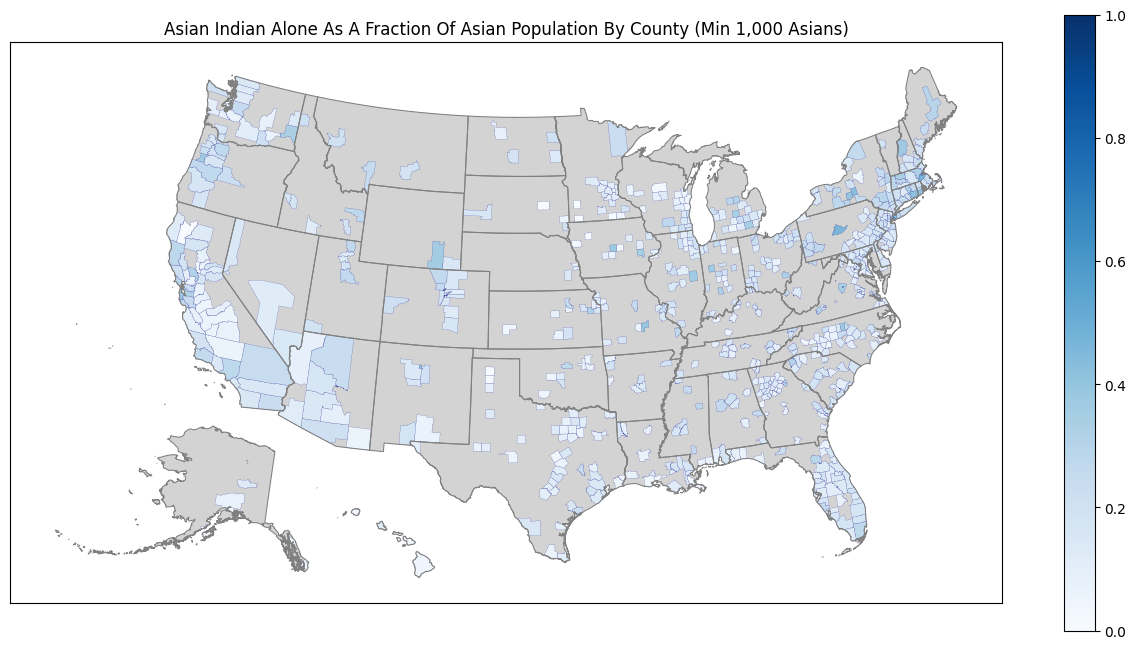

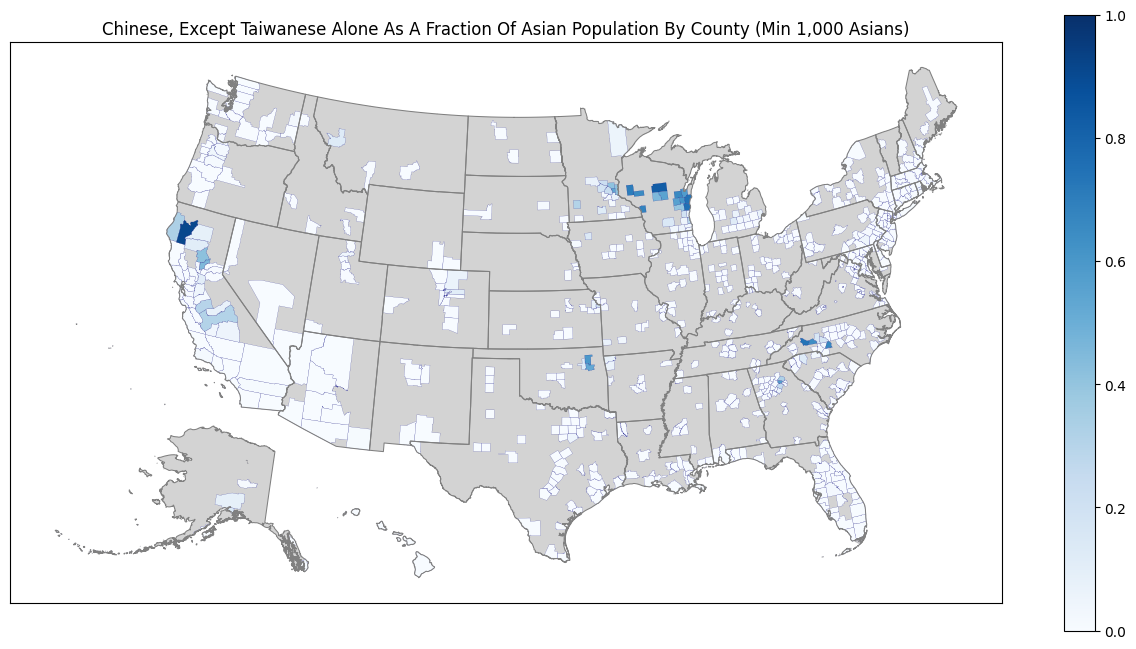

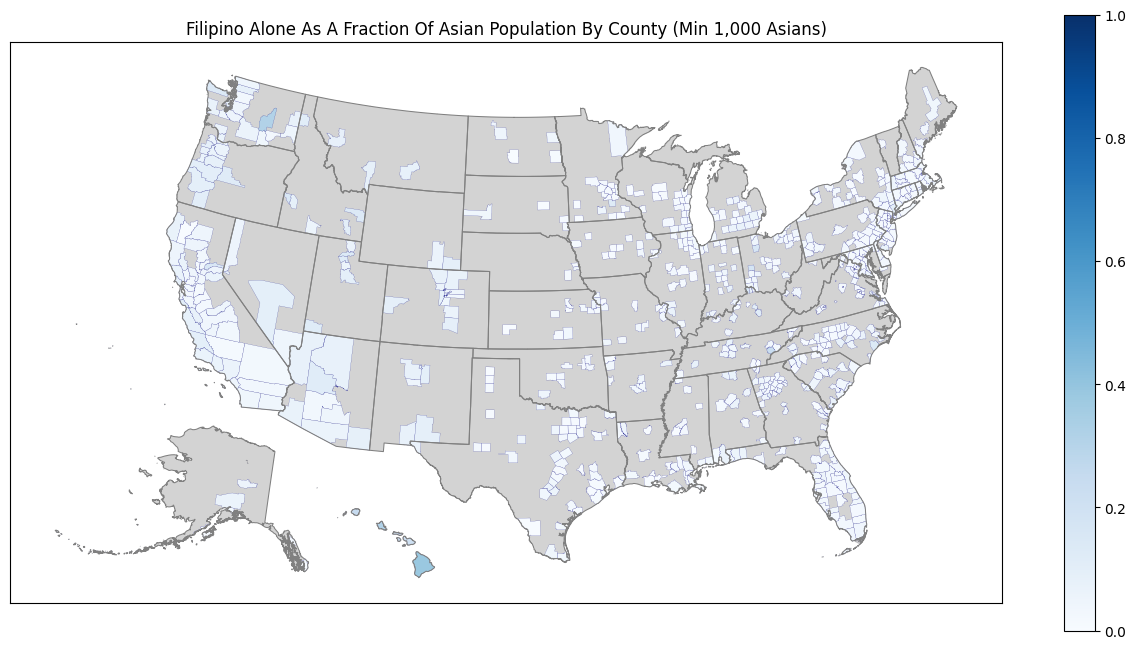

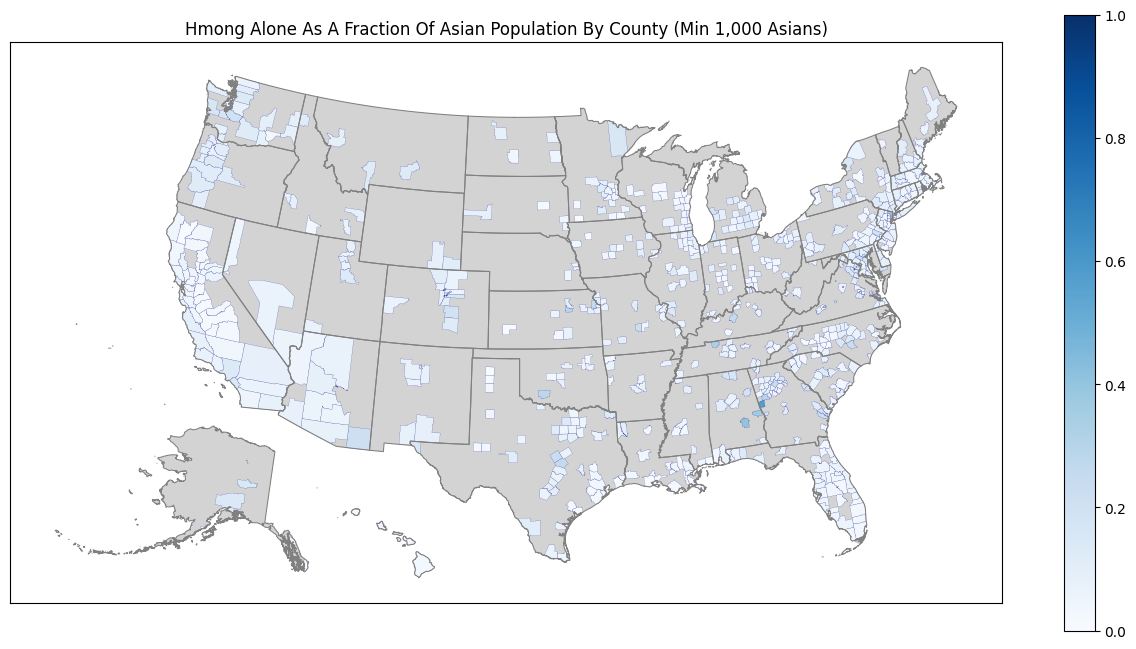

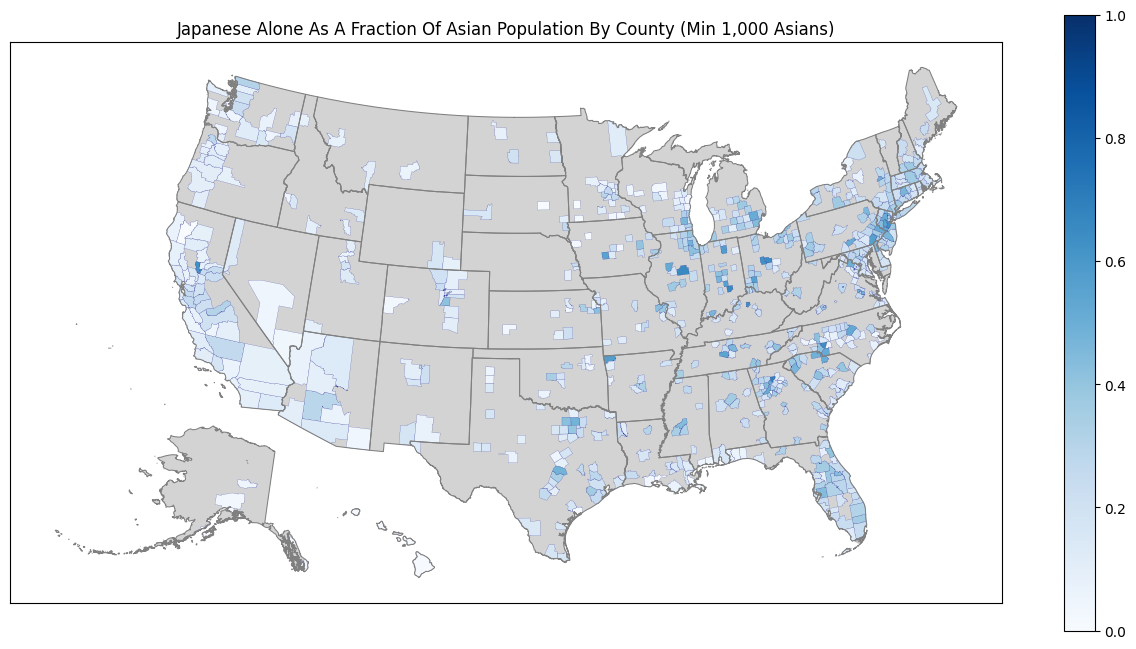

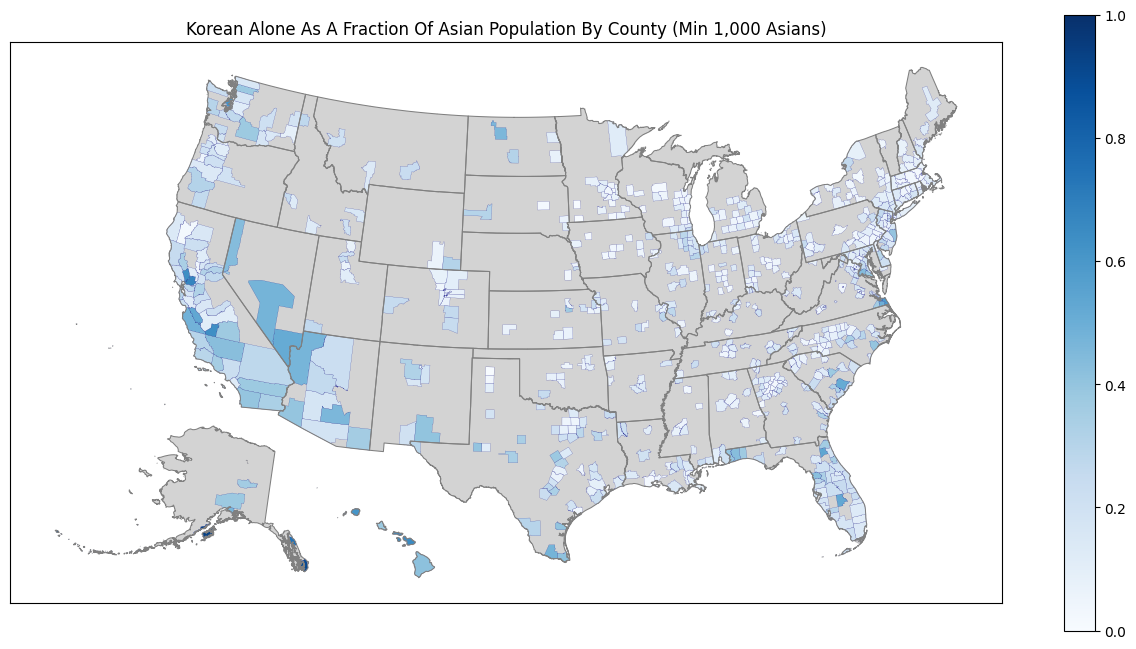

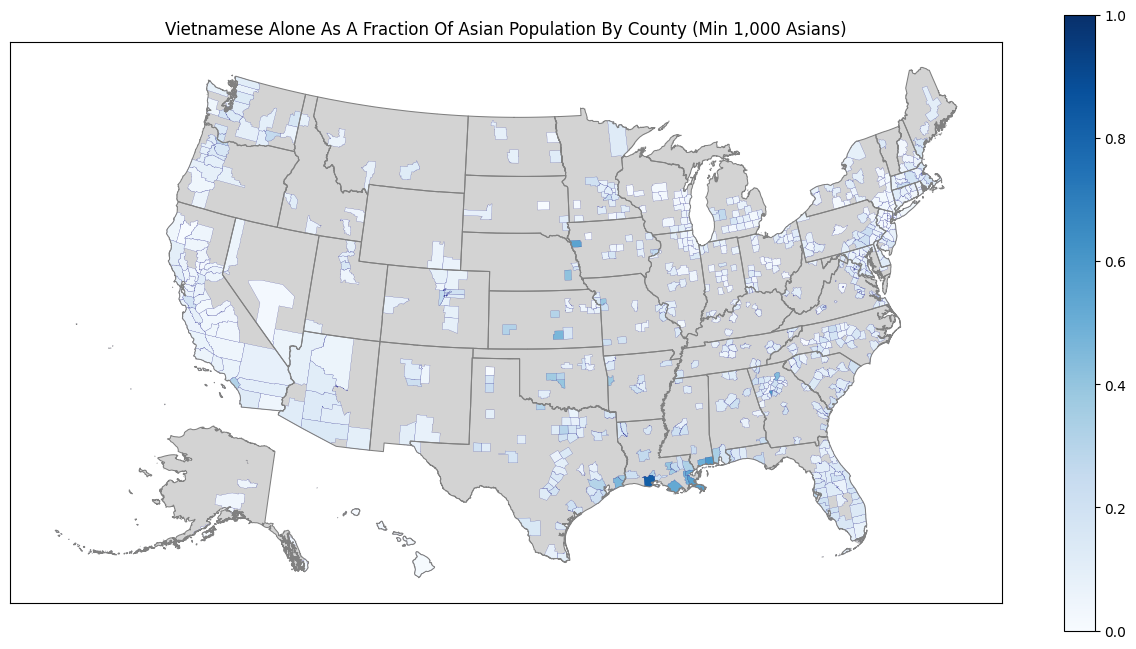

In [31]:
for popgroup_label in df_groups["POPGROUP_LABEL"]:
    column = f"Percent {popgroup_label}"

    ax = cem.plot_us(
        gdf_states,
        color="lightgray",
        figsize=(16, 8),
    )

    ax = cem.plot_us(
        gdf_popgroup_counts,
        column,
        legend=True,
        cmap="Blues",
        edgecolor="navy",
        linewidth=0.1,
        vmin=0.0,
        vmax=1.0,
        ax=ax,
    )

    ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.75, ax=ax)
    _ = ax.set_title(
        f"{popgroup_label} as a Fraction of Asian Population by County (Min 1,000 Asians)".title()
    )